<a href="https://colab.research.google.com/github/gulmert89/projects/blob/main/hackathon_for_good_india/cityforfood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon for Good India: Code Base of Team-CityForFood

Soil temperature directly affects plant growth.  In other words, nearly every crop slows down its growth when soil temperatures are below 9 and above 50 degree Celsius. Germination of various seeds requires different soil temperature ranges.  For example, maize starts to germinate at soil temperatures from 7 to 10 degree. Most organisms within soil thrive at temperatures between 25-35 degrees. Nitrification requires a soil temperature of 32C.<br>

An AI model which gives the farmers estimates about the crop growth, the crop yield, and recommendations for products to make the yield better.

Since it is not always possible to get soil information (but relatively easy to obtain weather data), we created a model that predicts the **soil temperature** by using only three information in this hackathon's scope:<br>
* **Temperature (C)**
* **Relative Humidity (%)**
* **Wind Speed (km/h)** 

The only thing farmer should do is open his/her Location Services on the cellphone and the application will show the farmer (and the expert at the other side as well) the required data like:

* Weather Forecast Summary
* Temperature
* Soil Temperature
* Predicted Soil Temperature **(Using Deep Learning model)**
* Soil Moisture
* Humidity
* Air Quality Index etc.

According to the temperature, the expert and the farmer will know if planting their seeds is suitable at that time frame or not.

Also,<br>
The app will provide a QR Code that shows these specifications listed above to the farmer. So if he/she likes, this QR Code could be attached to the product so that the customer gets information about the food that is harvested at that time.
***

# 1\. Introduction

## 1.1 Importing Our Modules

In [ ]:
import os
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2 Cosmetic Configurations

In [ ]:
sns.set_style(style="whitegrid")

title_font = {"family":"sans-serif", 
              "weight":"bold", 
              "color":"darkgreen", 
              "size":16}

axis_font = {"family":"serif", 
             "weight":"normal", 
             "color":"darkgreen", 
             "size":14}

# 2\. The Database
Pulling data from Ambee Database

In [ ]:
url_soil_history = "https://api.ambeedata.com/soil/history/by-lat-lng?\
lat=17.39359&lng=78.4642&\
startDate=2018-01-01T12:16:44&endDate=2020-11-11T12:16:44"

querystring_soil = {}
headers = {
    'x-api-key': "BkY0NYZmqG3PEJ776SjzzajD1VsdqZrh6CkyAqUt",
    'Content-type': "application/json"}

response_soil = requests.request("GET", url_soil_history, 
                                 headers=headers, 
                                 params=querystring_soil)

In [ ]:
response_dict_soil = eval(response_soil.text)["data"]
response_dict_soil = pd.DataFrame(response_dict_soil).iloc[:, 1:]

In [ ]:
response_dict_soil.tail()

,scantime,soil_temperature,soil_moisture
19,2020-10-05T08:04:08.123Z,28.450006,16.000000
20,2020-10-03T08:16:30.455Z,29.350000,19.333334
21,2020-10-03T08:16:28.955Z,28.850000,14.000000
22,2020-10-01T08:29:13.789Z,27.050012,15.666667
23,2020-10-01T08:29:12.289Z,27.350000,15.666667


As can be seen above, there are only 23 data pulled on the database. Our deep learning model wouldn't be able to extract features and learn the patterns out of such a small dataset. We need to acquire at least a couple of hundred data to train our model.<br>Another source is used and can be visited from this [link](https://www.meteoblue.com/en/weather/archive/export/hyderabad_india_1269843?daterange=2020-11-07%20to%202020-11-21&min=2020-11-07&max=2020-11-21&domain=NEMSAUTO&params=&params%5B%5D=temp2m&params%5B%5D=relhum2m&params%5B%5D=precip&params%5B%5D=sunshine&params%5B%5D=swrad&params%5B%5D=directrad&params%5B%5D=diffuserad&params%5B%5D=wind%2Bdir10m&params%5B%5D=soiltemp0to10&params%5B%5D=soilmoist0to10&utc_offset=5.5&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric). The location is selected as: **Hyderabad**

In [ ]:
soil_df = pd.read_csv("weather_and_soil_data.csv")
soil_df.head(10)

,location,Hyderabad,Hyderabad.1,Hyderabad.2,Hyderabad.3,Hyderabad.4
0,lat,17.39359,17.39359,17.39359,17.39359,17.39359
1,lon,78.4642,78.4642,78.4642,78.4642,78.4642
2,timestamp,Temperature ( C),Relative Humidity (%),Wind Speed (km/h),Soil Moisture (m3/m3),Soil Temperature ( C)
3,20201107T0000,23.6929,74,6.924738,0.218,24.690002
4,20201107T0100,23.1429,77,6.9527545,0.218,24.179993
5,20201107T0200,22.6429,80,7.10031,0.218,23.730011
6,20201107T0300,22.1929,82,7.2,0.218,23.330017
7,20201107T0400,21.8229,84,7.10031,0.219,22.970001
8,20201107T0500,21.4929,87,6.6087217,0.219,22.640015
9,20201107T0600,21.2029,89,5.815978,0.219,22.360016


# 3\. Data Cleaning and Preparation

## 3.1 Getting The Dataset Ready

In [ ]:
soil_df.columns = list(soil_df.iloc[2, :])
soil_df = soil_df.iloc[3:, :]
soil_df.reset_index(inplace=True)
soil_df.drop(["index", "Soil Moisture (m3/m3)"], axis=1, inplace=True)

convert_columns = list(soil_df.columns[1:])
soil_df[convert_columns] = soil_df[convert_columns].astype("float32")

In [ ]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              360 non-null    object 
 1   Temperature ( C)       360 non-null    float32
 2   Relative Humidity (%)  360 non-null    float32
 3   Wind Speed (km/h)      360 non-null    float32
 4   Soil Temperature ( C)  360 non-null    float32
dtypes: float32(4), object(1)
memory usage: 8.6+ KB


Now we have 360 data points instead of 23. This is still quite low for a deep learning model but it was not possible due to website restrictions.<br>We can see the cleaned data frame just below.

In [ ]:
soil_df.head()

,timestamp,Temperature ( C),Relative Humidity (%),Wind Speed (km/h),Soil Temperature ( C)
0,20201107T0000,23.692900,74.0,6.924738,24.690002
1,20201107T0100,23.142900,77.0,6.952754,24.179993
2,20201107T0200,22.642900,80.0,7.100310,23.730011
3,20201107T0300,22.192900,82.0,7.200000,23.330017
4,20201107T0400,21.822901,84.0,7.100310,22.970001


## 3.2 Preprocessing Our Data

In [ ]:
from keras import models, layers
from keras.optimizers import Adam, schedules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
X_train = np.array(soil_df.drop(["Soil Temperature ( C)", "timestamp"], axis=1))
y_train = np.array(soil_df["Soil Temperature ( C)"])
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.20,
                                                    shuffle=True)

In [ ]:
scale = StandardScaler()
normalize = MinMaxScaler((0, 1))

# normalized set: values are between [0, 1]
X_train = normalize.fit_transform(X_train)
X_test = normalize.fit_transform(X_test)

# 4\. Creating The Model

## 4.1 Monitoring The Performance
Here we prepare the TensorBoard configuration to monitor the model's performance below. After creating and running the model, we will constantly refer to TensorBoard API shown below.

In [ ]:
# Load the TensorBoard notebook extension:
from keras.callbacks import TensorBoard
from tensorboard import notebook as tb_notebook
%load_ext tensorboard

In [ ]:
# To run the TensorBoard:
%tensorboard --logdir my_log_dir

We replaced the API with these sample images since the API itself only works while the codes are running too.<br>The main idea here is to reduce the cost function's output and get the minimum loss out of it. It can be seen from the graphs that multiple models were tried and the most successful one was selected so that the **Mean Absolute Error (MAE)** hit the minimum value.

![TensorBoard Example 1](https://i.pinimg.com/originals/2b/b2/57/2bb257362000ecd24cfdb8c2deef18d4.jpg)

Above graph tells us that after nearly 200 trials (epochs), the model succeeded to minimize the loss function and it became almost zero. However we kept it running up to 1000 epochs to make sure mean absolute error hit zero as well. 

The structure of our sample models:

![TensorBoard Example 2](https://i.pinimg.com/originals/25/b0/77/25b077ed32708a7f844d3d37d2cbb729.png)

## 4.2 Prepare The Model

In [ ]:
# to avoid repeating the layers
def dense_layer(unit):
    model.add(layers.Dense(units=unit))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.15))

In [ ]:
model = models.Sequential()
model.add(layers.Dense(units=128,
                       input_shape=(X_train.shape[1], ), 
                       kernel_initializer="GlorotUniform", 
                       name="Hidden_Layer1"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
dense_layer(128)
dense_layer(256)
dense_layer(256)
model.add(layers.Dense(1, name="Output_Layer"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer1 (Dense)        (None, 128)               512       
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

To predict the soil temperature, the model used more than 100,000 parameters, 5 hidden layers and hundreds of neurons.

## 4.2 Run!

In [ ]:
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                         decay_steps=10000,
                                         decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

# TensorBoard configuration:
# create a folder for log files
my_log_dir = os.path.join("my_log_dir", 
                    datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))
tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, histogram_freq=1)

# firstly, we compile our model before we fit the data
model.compile(optimizer=opt, loss="mse", metrics=["mae"])
model_history = model.fit(X_train, y_train, 
                          epochs=1000, 
                          batch_size=8, 
                          validation_split=0.25, 
                          shuffle=True, 
                          verbose=0, 
                          callbacks=[tensorboard_callbacks])

In [ ]:
# we should save the most successful model:
model.save("soil_model.h5")
evaluate_dict = model.evaluate(X_test, y_test, return_dict=True)

3/3 [==============================] - 0s 3ms/step - loss: 1.9529 - mae: 0.8691


In [ ]:
print(f'The evaluation loss value of the test dataset : {evaluate_dict["loss"]:.3f}')
print(f'Mean Absolute Error (MAE) of the test dataset : {evaluate_dict["mae"]:.3f}')

The evaluation loss value of the test dataset : 1.953
Mean Absolute Error (MAE) of the test dataset : 0.869


Please note that we have a MAE value of 0.87. It means that the mean error is about 0.9 while predicting the temperature. We would have a predicted value of **21.0** celsius degree whereas the true value was 21.6, 21.8 or even 20. Remember the more data we get, the better deep learning models learn from our data. Instead of a few hundred data, we should have thousands of data points to feed our model so it could reduce the loss value and got a smaller mean error.

In [ ]:
example_soilTemp_prediction = model.predict(X_test)[1][0]
example_soilTemp_trueValue = y_test[1]

print(f"Predicted soil temperature : {example_soilTemp_prediction:.2f}C")
print(f"True soil temperature      : {example_soilTemp_trueValue:.2f}C")

Predicted soil temperature : 28.27C
True soil temperature      : 28.11C


...and sometimes it does a pretty good job as well as can be seen.

# 5\. QR Code

## 5.1 Load The Trained Deep Learning Model

We don't need to train our model everytime we want to predict the temperature. It would cost us lots of hours. Instead, we load our best model from a file we saved just after we trained it.

In [ ]:
model_preload = models.load_model("soil_model.h5")

In [ ]:
# We need to update/install the qr-code module
!pip install qrcode
import qrcode

## 5.2 Latest Weather Data

We use Ambee database to get the latest weather forecast information from the farmer's location.

In [ ]:
url_airLatest = " https://api.ambeedata.com/latest/by-lat-lng"
url_weather = "https://api.ambeedata.com/weather/by-lat-lng"
url_soil = "https://api.ambeedata.com/soil/latest/by-lat-lng"

querystring_latest = {"lat":"17.39359",
                      "lng":"78.4642"}

headers = {
    'x-api-key': "BkY0NYZmqG3PEJ776SjzzajD1VsdqZrh6CkyAqUt",
    'Content-type': "application/json"
    }

response_airLatest = requests.request("GET", url_airLatest, 
                                       headers=headers, 
                                       params=querystring_latest)
response_weather = requests.request("GET", url_weather, 
                                    headers=headers, 
                                    params=querystring_latest)
response_soil = requests.request("GET", url_soil, 
                                 headers=headers,
                                 params=querystring_latest)

In [ ]:
false = False    # to correct an error on API server,
true = True      # these booleans had to be defined.

# sometimes we might have server errors
try:
    response_dict_airLatest = eval(response_airLatest.text)
    response_dict_airLatest = response_dict_airLatest["stations"][0]
    response_dict_weather = eval(response_weather.text)
    response_dict_weather = response_dict_weather["data"]
    response_dict_soil = eval(response_soil.text)
    response_dict_soil = response_dict_soil["data"][0]
except:
    print("500 - Internal Server Error: Something went wrong on our end")

Down below, the pulled data can be seen. We should convert it so a non-technical person would understand.

In [ ]:
response_dict_weather

{'apparentTemperature': 70.75,
 'cloudCover': 0.82,
 'dewPoint': 67.3,
 'humidity': 0.92,
 'icon': 'partly-cloudy-night',
 'lat': '17.39359',
 'lng': '78.4642',
 'ozone': 250,
 'precipIntensity': 0.0018,
 'precipProbability': 0.03,
 'precipType': 'rain',
 'pressure': 1013.2,
 'summary': 'Mostly Cloudy',
 'temperature': 69.75,
 'time': 1606000188,
 'uvIndex': 0,
 'visibility': 10,
 'windBearing': 54,
 'windGust': 6.81,
 'windSpeed': 3.21}

In [ ]:
response_dict_soil

{'_id': '5f93cbe7044ab9f9d479d5b7',
 'scantime': '2020-10-21T08:03:36.102Z',
 'soil_moisture': 24.33333396911621,
 'soil_temperature': 23.050012207031273}

In [ ]:
# latest air information
QR_AIR_AQI = response_dict_airLatest["AQI"]
QR_AIR_AQI_label = response_dict_airLatest["aqiInfo"]["category"]

# latest weather information
# Temperature is in F. If pulled data in C, please modify the following line
QR_W_TEMP = (response_dict_weather["temperature"]-32) * (5/9)
QR_W_HUMID = response_dict_weather["humidity"] * 100
QR_W_PROB_label = response_dict_weather["precipType"]
QR_W_PROB = response_dict_weather["precipProbability"] * 100
QR_W_SUM = response_dict_weather["summary"]
QR_W_UV = response_dict_weather["uvIndex"]
QR_W_WIND = response_dict_weather["windSpeed"]

In [ ]:
current_Soil_Data = np.array([[QR_W_TEMP, 
                               QR_W_HUMID, 
                               QR_W_WIND]])
current_Soil_Data = normalize.fit_transform(current_Soil_Data)

soil_tmp_prediction = model_preload.predict(current_Soil_Data)

In [ ]:
# latest soil information
QR_SOIL_MOIST = response_dict_soil["soil_moisture"]
QR_SOIL_TEMP = response_dict_soil["soil_temperature"]
QR_SOIL_TEMP_predict = soil_tmp_prediction[0][0]

# if the soil data is not available:
if not isinstance(QR_SOIL_MOIST, (int, float)):
    QR_SOIL_MOIST = np.nan
if not isinstance(QR_SOIL_TEMP, (int, float)):
    QR_SOIL_TEMP = np.nan

## 5.3 Getting The QR Code Image

In [ ]:
QR_read_me = f"""
Summary: {QR_W_SUM}
Temperature: {QR_W_TEMP:.2f} C
Soil Temperature: {QR_SOIL_TEMP:.2f} C
Predicted Soil Temperature: {QR_SOIL_TEMP_predict:.2f} C
Soil Moisture: {QR_SOIL_MOIST:.2f}%
Humidity: {int(QR_W_HUMID)}%
Air Quality Index: {int(QR_AIR_AQI)} ({QR_AIR_AQI_label})
Probability of precipitation: {int(QR_W_PROB)}% ({QR_W_PROB_label})
UV Index: {int(QR_W_UV)}
Wind Speed: {QR_W_WIND:.2f}km/h
"""

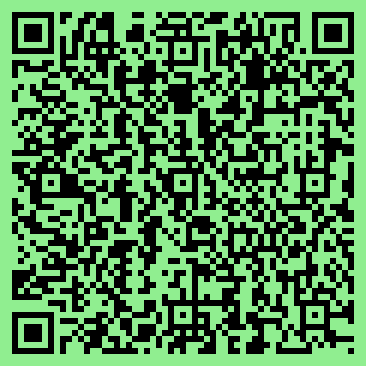

In [ ]:
sns.reset_orig()
QR = qrcode.QRCode(version=None, 
                   error_correction=qrcode.constants.ERROR_CORRECT_L,
                   box_size=6, 
                   border=2)
QR.add_data(QR_read_me)
QR.make(fit=True)

img = QR.make_image(fill_color="black", back_color="lightgreen")
img.get_image()

Finally, the farmer, expert or customer can use the camera (or a QR Code reader app) and scan the QR code to get information about these specifications:<br>

* Weather Forecast Summary
* Temperature
* Soil Temperature
* **Predicted Soil Temperature** *(Final product of our model)*
* Soil Moisture
* Humidity
* Air Quality Index
* Probability of precipitation
* UV Index
* Wind Speed